# Tutorial - Lagged Choices

The models in Keane and Wolpin (1994) and the extended model in Keane and Wolpin (1997) require information on the previous choice as lagged choices have an influence on utility by modeling switching costs, etc.. In contrast, the basic model in Keane and Wolpin (1997) does not require this information. This notebook shows the effects of including previous choices in your model.

*If you want to know how to simulate models with different distributions of previous choices, see the [tutorial on initial conditions](tutorial-initial-conditions.ipynb).*

In [2]:
import respy as rp

## How to define lagged choices

The number of lags is inferred from the definition of covariates, because lagged choices are only relevant for the model if they influence the utility of individuals. The lags have to be called ``lagged_choice_1``, ``lagged_choice_2``, and so on. Let us take a look at the covariates from the extended model in Keane and Wolpin (1997).

In [3]:
params, options = rp.get_example_model("kw_97_extended", with_data=False)

The covariates are stored in a dictionary where the key matches parameter names from ``params`` and the value is the definition of the covariate. The definition is passed to :func:`pandas.DataFrame.eval` and constructs the covariate with the available information in the DataFrame. Covariates are constructed sequentially which allows to reuse previously constructed covariates in following definitions. For more information on :func:`pandas.DataFrame.eval` see the the [official documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.eval.html) or this [StackOverflow post](https://stackoverflow.com/a/53779987) called the "Missing Manual".

Depending on the internal routine, most information of the state space, like period, experiences, lagged choices, are available. ``exp_*`` is the code to target the experience in one choice where the choice name has to be consistently used in ``params``. Lagged choices are defined internally as a [``pandas.Categorical``](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html) and can be compared to choice names. Even expressions as ``lagged_choice_1 in ['a', 'b']`` are possible.

In [3]:
options["covariates"]

{'not_exp_a_lagged': "exp_a > 0 and lagged_choice_1 != 'a'",
 'not_exp_b_lagged': "exp_b > 0 and lagged_choice_1 != 'b'",
 'work_a_lagged': "lagged_choice_1 == 'a'",
 'work_b_lagged': "lagged_choice_1 == 'b'",
 'edu_lagged': "lagged_choice_1 == 'edu'",
 'not_any_exp_a': 'exp_a == 0',
 'not_any_exp_b': 'exp_b == 0',
 'not_any_exp_mil': 'exp_mil == 0',
 'any_exp_a': 'exp_a > 0',
 'any_exp_b': 'exp_b > 0',
 'any_exp_mil': 'exp_mil > 0',
 'hs_graduate': 'exp_edu >= 12',
 'co_graduate': 'exp_edu >= 16',
 'is_return_not_high_school': '~edu_lagged and ~hs_graduate',
 'is_return_high_school': '~edu_lagged and hs_graduate',
 'is_minor': 'period < 2',
 'is_young_adult': '2 <= period <= 4',
 'is_adult': '5 <= period',
 'constant': '1',
 'exp_a_square': 'exp_a ** 2 / 100',
 'exp_b_square': 'exp_b ** 2 / 100',
 'exp_mil_square': 'exp_mil ** 2 / 100',
 'mil_dropout': 'exp_mil == 1',
 'up_to_nine_years_edu': 'exp_edu <= 9',
 'at_least_ten_years_edu': '10 <= exp_edu'}

The introduction of lagged choices leads to impossible combinations or inadmissible states in the state space. E.g. if an individual has always engaged in a choice with experience, the individual cannot have a different choice as the lagged choice. These inadmissible states are a computational burden for the model because a solution for the optimal decision in this state is obtained despite that no individual will ever reach this state. Thus, ``respy`` has ``"core_state_space_filters"`` to purge those states from the state space. Every entry in the list is a boolean expression which evaluates to ``True`` for inadmissible states.

To limit redundancy, the expressions in the curly braces are placeholder for certain kinds of choices. ``"{i}"`` will be replaced with every choice with experience accumulation. ``"{j}"`` will be replaced with every choice without experience accumulation. At last, ``"{k}"`` will be replaced with choices with a wage component.

In [4]:
options["core_state_space_filters"]

["period > 0 and exp_{i} == period and lagged_choice_1 != '{i}'",
 "period > 0 and exp_a + exp_b + exp_mil + exp_edu == period and lagged_choice_1 == '{j}'",
 "period > 0 and lagged_choice_1 == 'edu' and exp_edu == 0",
 "lagged_choice_1 == '{k}' and exp_{k} == 0",
 "period == 0 and lagged_choice_1 == '{k}'"]

The name core state space refers to the fact that periods, experiences and lagged choices form a core of the model. The space defined by the former dimensions is sparse as not every combination between the dimensions is possible. In contrast, there exist a dense space formed by, e.g., types because every combination of states in the core state space with every type exists.

## Lagged choices and model complexity

In this section, the base and extended model of Keane and Wolpin (1997) are compared. The base model does not require any information on the occupational history. Thus, the state space is a lot smaller. The state space increases approximately by a factor of

$$
    \texttt{n_choices}^\texttt{n_lags}
$$

Indeed, as you can see in the following graphic, the total number of states in the base model is 12.99 Mio. and 59.3 Mio. in the extended model. The filters reduced around 5 Mio. states.

In [5]:
state_space_extended = rp.solve(params, options)

/data/homes/iza25808/respy/respy/pre_processing/model_processing.py:157: UserWarning: The shares of initial experiences for choice 'edu' do not sum to one. Shares are divided by their sum for normalization.
  category=UserWarning,


In [6]:
params, options = rp.get_example_model("kw_97_base", with_data=False)

In [7]:
state_space_base = rp.solve(params, options)

/data/homes/iza25808/respy/respy/pre_processing/model_processing.py:157: UserWarning: The shares of initial experiences for choice 'edu' do not sum to one. Shares are divided by their sum for normalization.
  category=UserWarning,


In [8]:
states_per_period_extended = [
    len(range(slice_.start, slice_.stop))
    for slice_ in state_space_extended.slices_by_periods
]

states_per_period_base = [
    len(range(slice_.start, slice_.stop))
    for slice_ in state_space_base.slices_by_periods
]

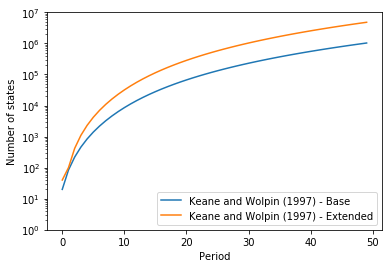

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

for states_per_period in [states_per_period_base, states_per_period_extended]:
    ax.semilogy(range(0, len(states_per_period)), states_per_period)
    
ax.set_ylim(1, 1e7)

ax.set_xlabel("Period")
ax.set_ylabel("Number of states")

ax.legend(["Keane and Wolpin (1997) - Base", "Keane and Wolpin (1997) - Extended"], loc="lower right");